In [104]:
#TP1 - KMeans

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
#import random

from scipy.io import arff
from enum import Enum

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
from sklearn.datasets import make_blobs


In [84]:
# Tools functions (Extraction, preparation, filter, plot, ...)
PATH = "artificial/"
name_file = "banana.arff"

def extractDataAndPrepareData(path_file):
    """
    load file and return desired data
    """
    a_path_file = path_file.split(".")
        
    if(a_path_file[1]=="arff"):
        data = arff.loadarff(open(path_file,'r'))[0]
        
        i=-1
        for feat in data[0]: i=i+1
        nb_features = i

        # Create an array(features) <=> array(array(feature)) 
        X = []
        for elem in data:
            point = [elem[i] for i in range(nb_features)]
            X.append(point)
        return X
    
    elif(a_path_file[1]=="data"):
        f = open(path_file, 'r')
        X = []
        lines = f.readlines()
        for line in lines:
            features = line.split("\t")
            point = [float(feat) for feat in features]
            X.append(point)

        return X
    else:
        raise Exception("Error Type of document unknown > {}".format(a_path_file[1]))

PATH = "dataset/"
name_file = "a.data"
X = extractDataAndPrepareData(PATH+name_file)
#print(X)


def filterNoise(X,labels,filter_value=-1):
    """
    Return a list X and associated label filtered from label = filter_value
    """
    new_X = []
    new_labels = []
    for i,label in enumerate(labels):
        if(label!=filter_value):
            new_X.append(X[i])
            new_labels.append(labels[i])      
    return new_X,new_labels

def showData(X):
    fig = plt.figure()
    if(np.shape(X)[1]==2): # 2D
        xs = [point[0] for point in X]
        ys = [point[1] for point in X]

        plt.scatter(xs,ys,s=10)
        plt.show()  
    elif(np.shape(X)[1]==3): # 3D
        ax = fig.add_subplot(projection='3d')

        xs = [point[0] for point in X]
        ys = [point[1] for point in X]
        zs = [point[2] for point in X]

        ax.scatter(xs,ys,zs,s=10)
        plt.show()

def showClusters(X,labels,title):
    """
    Plot cluster labeled with colors
    """
    fig = plt.figure()

    if(np.shape(X)[1]==2): # 2D
        xs = [point[0] for point in X]
        ys = [point[1] for point in X]

        plt.scatter(xs,ys,s=10,c=labels,cmap="rainbow")
        plt.show()  
    elif(np.shape(X)[1]==3): # 3D
        ax = fig.add_subplot(projection='3d')

        xs = [point[0] for point in X]
        ys = [point[1] for point in X]
        zs = [point[2] for point in X]

        ax.scatter(xs,ys,zs,s=10,c=labels,cmap='rainbow')
        ax.set_title(title)
        plt.show()
    else:
        print("Impossible to plot more than 3D graph")
    
def showGridClusters(X,lst_labels,lst_names):
    """
    Plot a grid of cluster labeled with colors
    """
    n_plot = np.shape(lst_labels)[0]
    n_features = np.shape(X)[1]
    
    n_row = math.ceil(n_plot/2)
    n_col = 2
    
    #print(f'n_plot = {n_plot} => n_row = {n_row} n_col = {n_col}')

    grid = plt.GridSpec(n_row, n_col, wspace=1, hspace=1)



    for i,labels in enumerate(lst_labels):
        row = math.floor(i/n_row)
        col = i%n_col
        #print(f'row = {row} col = {col}')
        if(n_features==2): # 2D
            ax = plt.subplot(grid[row,col])   

            xs = [point[0] for point in X]
            ys = [point[1] for point in X]

            ax.scatter(xs,ys,s=10,c=labels,cmap="rainbow")
            ax.set_title(lst_names[i])

        elif(n_features==3): # 3D     
            ax = plt.subplot(grid[row,col],projection="3d")  

            xs = [point[0] for point in X]
            ys = [point[1] for point in X]
            zs = [point[2] for point in X]

            ax.scatter(xs,ys,zs,s=10,c=labels,cmap="rainbow")
            ax.set_title(lst_names[i])

    plt.show()  




In [54]:
# Metrics
class MetricType(Enum):
    Silhouette=1
    DaviesBouldin=2
    
def getScoreClustering(X,labels,metric_type:MetricType,args=None):
    """
    Switch of methods depending on metric_type
    Return score 
    """
    def getScoreSilhouette(X,labels,args=None):
        return metrics.silhouette_score(X, labels, metric='euclidean')

    def getScoreDaviesBouldin(X,labels,args):
        return - metrics.davies_bouldin_score(X, labels)
    
    switcher = {
        MetricType.Silhouette: getScoreSilhouette,
        MetricType.DaviesBouldin: getScoreDaviesBouldin
    }
    # Get the function from switcher dictionary
    func = switcher.get(metric_type, lambda: "Invalid metric type")
    # Execute the function
    return func(X,labels,args)
    

In [12]:
# KMeans
def findBestParametersKMeans(X,lst_n_clusters:int,metric_type:int,verbose=False):
    """
    Loop into lst_n_clusters to find best n_cluster for KMeans  
    """
    # Set best score and index
    best_score = -float('inf')
    index_best = None
    
    # Loop into different values of n_clusters 
    for i,n_clusters in enumerate(lst_n_clusters):
        if verbose: print("{}%".format((i/np.size(lst_n_clusters))*100)) # percent print at each step
        kmeans = KMeans(n_clusters=n_clusters,init='k-means++').fit(X) # Clustering algo
        score =  getScoreClustering(X, kmeans.labels_, metric_type) # update score
        if(score>best_score): # save best score index
            best_score = score
            index_best = i
            
    return lst_n_clusters[index_best]

def makeKMeans(X,metric_type:int,display=False,verbose=False):
    """
    Find best clustering with KMeans
    """
    # Create list of possible number of clusters
    lst_n_clusters = [i for i in range(2,MAX_N_CLUSTERS)]
    
    # Find best parameters
    best_n_clusters = findBestParametersKMeans(X,lst_n_clusters,metric_type,verbose)
    
    # Print best solution
    print("Best match is {} clusters".format(best_n_clusters))
    kmeans = KMeans(n_clusters=best_n_clusters,init='k-means++').fit(X) 
    if display: showClusters(X,kmeans.labels_,"KMeans") # Display solution
    return kmeans.labels_

In [28]:
# AgglomerativeClustering        
def findBestParametersAgglomerativeClustering(X,lst_n_clusters,metric_type:MetricType,linkage:str,verbose=False):
    """
    Loop into lst_n_clusters to find best n_cluster for AgglomerativeClustering 
    """
    # Set best score and index
    best_score = -float('inf')
    index_best = None
    
    # Loop into different values of n_clusters 
    for i,n_clusters in enumerate(lst_n_clusters):
        if verbose: print("{}%".format((i/np.size(lst_n_clusters))*100)) # percent print at each step
        clustering = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage).fit(X)# Clustering algo
        score =  getScoreClustering(X, clustering.labels_, metric_type)# update score
        if(score>best_score):# save best score index
            best_score = score
            index_best = i
            
    return lst_n_clusters[index_best]

def makeAgglomerativeClustering(X,metric_type:MetricType,display=False,verbose=False):
    """
    Find best clustering with AgglomerativeClustering for each linkage
    """
    # Create list of possible linkage and n_clusters
    linkage_list  = ["ward","complete","average","single"]
    lst_n_clusters = [i for i in range(2,MAX_N_CLUSTERS)]
    
    # Loop into and find best n_clusters for each linkage
    lst_labels = []
    for linkage in linkage_list:
        # Find best parameters
        best_n_clusters = findBestParametersAgglomerativeClustering(X,lst_n_clusters,metric_type,linkage,verbose)
        
        # print best solution for given linkage
        print("Best match is {} clusters  [linkage = {}, metrics = {}] ".format(best_n_clusters,linkage,metric_type)) 
        clustering = AgglomerativeClustering(n_clusters=best_n_clusters,linkage=linkage).fit(X)
        lst_labels.append(clustering.labels_)
        if(verbose): print("Clustering done for {}".format(linkage))


    if display: showGridClusters(X,lst_labels,linkage_list)   # Display best solution for each linkage
        
    return clustering

In [92]:
# DBSCAN
def findBestParametersDBSCAN(X,lst_eps,lst_min_n_samples,metric_type:MetricType,verbose=False):
    """
    Loop into lst_eps and lst_min_n_samples to find best eps and n_samples for DBSCAN 
    """
    # Set best score and index
    best_score = -float('inf')
    index_best_eps = None
    index_best_min_n_samples = None
    
    # Loop into different values of eps and n_samples 
    for i,eps in enumerate(lst_eps):
        if verbose: print(f'{(i/(np.size(lst_eps)))*100}%') # percent print at each step of eps
        for j,min_n_samples in enumerate(lst_min_n_samples):
            clustering = DBSCAN(min_samples=min_n_samples,eps=eps).fit(X) # Clustering algo
            if(len(set(clustering.labels_))>2): # If 2 clusters
                #new_X,new_labels = filter_list(X,clustering.labels_)
                score = getScoreClustering(X, clustering.labels_, metric_type)# update score
                if(score>best_score):# save best score index
                    best_score = score
                    index_best_eps = i
                    index_best_min_n_samples = j
                        
    return lst_eps[index_best_eps],lst_min_n_samples[index_best_min_n_samples]

def makeDBSCAN(X,metric_type:MetricType,display=True,verbose=False):
    """
    Find best clustering with DBSCAN
    """
    # Create list of possible linkage and n_clusters
    lst_eps = np.arange(START_EPS,END_EPS,STEP_EPS)
    lst_min_n_samples = [i for i in range(1,MAX_MIN_N_SAMPLES,STEP_SIZE_N_SAMPLES)]

    # find best eps and min_n_samples 
    best_eps,best_nb_samples = findBestParametersDBSCAN(X,lst_eps,lst_min_n_samples,metric_type,verbose)


    # print best solution for given linkage
    print(f'Best clustering with nb_samples = {best_nb_samples} and eps = {best_eps}')
    dbscan =  DBSCAN(min_samples=best_nb_samples,eps=best_eps).fit(X)
    if display: showClusters(X,dbscan.labels_,"DBSCAN")   # Display solution 
    
    return dbscan.labels_

In [77]:
# HDBSCAN
def findBestParametersHDBSCAN(X,lst_min_size_cluster,metric_type:MetricType,verbose=False):
    """
    Loop into lst_min_size_cluster to find best min_size_cluster for HDBSCAN  
    """
    # Set best score and index
    best_score = -float('inf')
    index_best = None
    
    # Loop into different values of n_clusters 
    for i,min_size_cluster in enumerate(lst_min_size_cluster):
        if verbose: print("{}%".format((i/np.size(lst_min_size_cluster))*100)) # percent print at each step
        hdbscan = HDBSCAN(min_cluster_size=min_size_cluster).fit(X) # Clustering algo
        score =  getScoreClustering(X, hdbscan.labels_, metric_type) # update score
        if(score>best_score): # save best score index
            best_score = score
            index_best = i
            
    return lst_min_size_cluster[index_best]

def makeHDBSCAN(X,metric_type:MetricType,display=True,verbose=False):
        """
        Find best clustering with KMeans
        """
        # Create list of possible number of clusters
        lst_min_cluster_size = [i for i in range(2,MAX_MIN_CLUSTER_SIZE)]

        # Find best parameters
        best_min_cluster_size = findBestParametersKMeans(X,lst_min_cluster_size,metric_type,verbose)

        # Print best solution
        print("Best match with min_cluster_size = {}".format(best_min_cluster_size))
        hdbscan = HDBSCAN(min_cluster_size=best_min_cluster_size).fit(X) # Clustering algo
        if display: showClusters(X,hdbscan.labels_,"HDBSCAN") # Display solution
        return hdbscan.labels_

In [70]:
class ClusteringType(Enum):
    KMeans=1
    AgglomerativeClustering=2
    DBSCAN=3
    HDBSCAN=4
    
# Choose clustering
def makeClustering(name_file:str,clustering_type:ClusteringType,metric_type:MetricType,
                       display:bool=True,verbose:bool=False):     
    
    # Extract data and prepare data
    X = extractDataAndPrepareData(name_file)

    
    switcher_algo = {
        ClusteringType.KMeans: makeKMeans,
        ClusteringType.AgglomerativeClustering: makeAgglomerativeClustering,
        ClusteringType.DBSCAN: makeDBSCAN,
        ClusteringType.HDBSCAN: makeHDBSCAN
    }
    # Get the function from switcher_algo dictionary
    algo = switcher_algo.get(clustering_type, lambda: "Invalid clustering type")
    
    # Execute the function
    start_time = time.time()
    labels = algo(X,metric_type,display,verbose) ###
    end_time =time.time()
    
    print(f'{clustering_type} with {metric_type}')
    print("--- %s seconds ---" % (end_time - start_time))
    return labels

In [17]:
for metric in MetricType: print(metric)
print()
for algo_name in ClusteringType: print(algo_name)

MetricType.Silhouette
MetricType.DaviesBouldin

ClusteringType.KMeans
ClusteringType.AgglomerativeClustering
ClusteringType.DBSCAN
ClusteringType.HDBSCAN


In [32]:
# CONSTANTS Clustering
MAX_N_CLUSTERS = 31 # KMeans and Agglomerative Clustering

PATH = "artificial/"
# KMeans
type_clustering = ClusteringType.KMeans

name_file = "banana.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2d-3c-no123.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "D31.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "dartboard1.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2sp2glob.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

KeyboardInterrupt: 

In [91]:
# CONSTANTS Clustering
MAX_N_CLUSTERS = 4 # KMeans and Agglomerative Clustering

PATH = "artificial/"
# Agglomerative Clustering
type_clustering = ClusteringType.AgglomerativeClustering

name_file = "banana.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2d-3c-no123.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "dartboard1.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2sp2glob.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

MAX_N_CLUSTERS = 31 # KMeans and Agglomerative Clustering

name_file = "D31.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

0.0%
50.0%
Best match is 3 clusters  [linkage = ward, metrics = MetricType.Silhouette] 
Clustering done for ward
0.0%


KeyboardInterrupt: 

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Best clustering with nb_samples = 11 and eps = 0.01


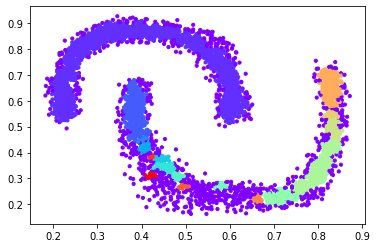

ClusteringType.DBSCAN with MetricType.Silhouette
--- 14.510390281677246 seconds ---
0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Best clustering with nb_samples = 1 and eps = 0.01


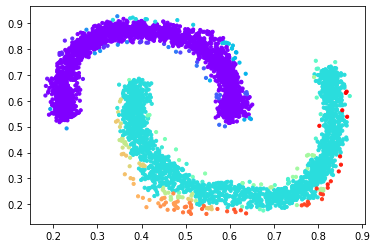

ClusteringType.DBSCAN with MetricType.DaviesBouldin
--- 12.514504194259644 seconds ---
Best clustering with nb_samples = 31 and eps = 0.31


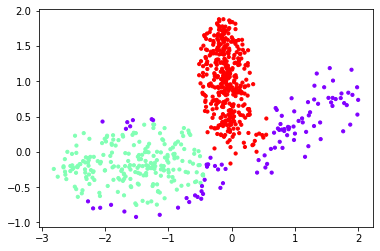

ClusteringType.DBSCAN with MetricType.Silhouette
--- 0.7070345878601074 seconds ---
Best clustering with nb_samples = 1 and eps = 0.01


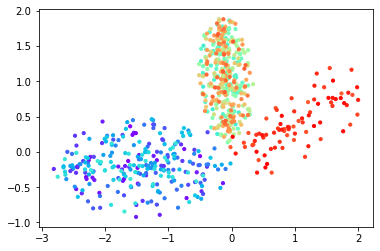

ClusteringType.DBSCAN with MetricType.DaviesBouldin
--- 0.8798058032989502 seconds ---
Best clustering with nb_samples = 31 and eps = 0.9099999999999999


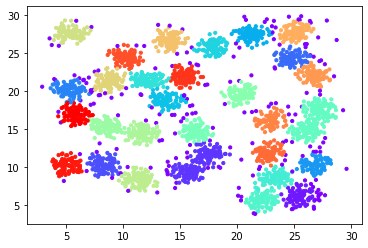

ClusteringType.DBSCAN with MetricType.Silhouette
--- 6.535408973693848 seconds ---
Best clustering with nb_samples = 1 and eps = 0.01


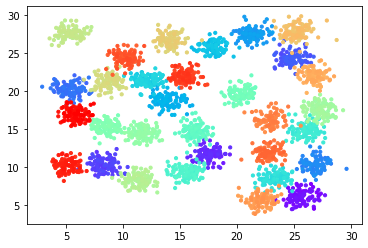

ClusteringType.DBSCAN with MetricType.DaviesBouldin
--- 3.0086138248443604 seconds ---
Best clustering with nb_samples = 1 and eps = 0.01


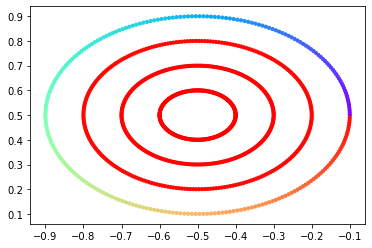

ClusteringType.DBSCAN with MetricType.Silhouette
--- 0.9388446807861328 seconds ---
Best clustering with nb_samples = 1 and eps = 0.01


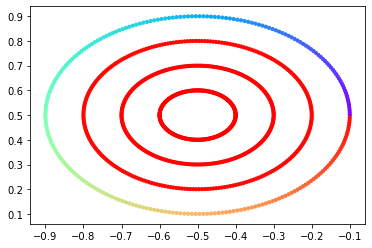

ClusteringType.DBSCAN with MetricType.DaviesBouldin
--- 1.0077767372131348 seconds ---
Best clustering with nb_samples = 1 and eps = 2.11


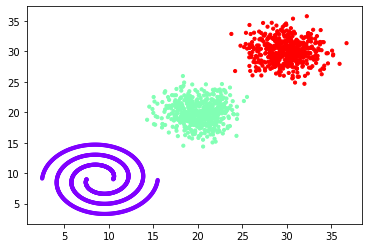

ClusteringType.DBSCAN with MetricType.Silhouette
--- 5.487441062927246 seconds ---
Best clustering with nb_samples = 1 and eps = 0.01


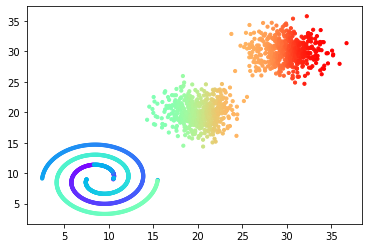

ClusteringType.DBSCAN with MetricType.DaviesBouldin
--- 2.053049325942993 seconds ---


array([   0,    1,    2, ..., 1996, 1997, 1998], dtype=int64)

In [94]:
# CONSTANTS Clustering
START_EPS,END_EPS,STEP_EPS = 0.01,3,0.3 # Only DBSCAN
MAX_MIN_N_SAMPLES,STEP_SIZE_N_SAMPLES = 50, 2 # Only DBSCAN

PATH = "artificial/"
# DBSCAN
type_clustering = ClusteringType.DBSCAN

name_file = "banana.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=True) # DaviesBouldin

name_file = "2d-3c-no123.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "D31.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "dartboard1.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2sp2glob.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

In [ ]:
# CONSTANTS Clustering
MAX_MIN_CLUSTER_SIZE = 50 # Only HDBSCAN

PATH = "artificial/"
# HDBSCAN
type_clustering = ClusteringType.HDBSCAN

name_file = "banana.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2d-3c-no123.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "D31.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "dartboard1.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

name_file = "2sp2glob.arff"
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=False) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=False) # DaviesBouldin

0.0%
2.083333333333333%
4.166666666666666%
6.25%
8.333333333333332%
10.416666666666668%
12.5%
14.583333333333334%
16.666666666666664%
18.75%
20.833333333333336%
22.916666666666664%
25.0%
27.083333333333332%
29.166666666666668%
31.25%
33.33333333333333%
35.41666666666667%
37.5%
39.58333333333333%
41.66666666666667%
43.75%
45.83333333333333%
47.91666666666667%
50.0%
52.083333333333336%
54.166666666666664%
56.25%
58.333333333333336%
60.416666666666664%
62.5%
64.58333333333334%
66.66666666666666%
68.75%
70.83333333333334%
72.91666666666666%
75.0%
77.08333333333334%
79.16666666666666%
81.25%
83.33333333333334%
85.41666666666666%
87.5%
89.58333333333334%
91.66666666666666%
93.75%
95.83333333333334%
97.91666666666666%
Best match with min_cluster_size = 8


UnboundLocalError: local variable 'hdbscan' referenced before assignment

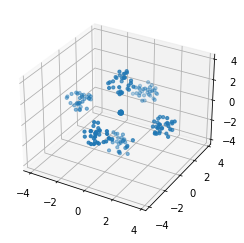

0.0%
50.0%
Best match is 3 clusters


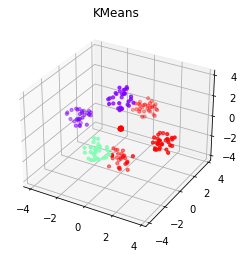

ClusteringType.KMeans with MetricType.Silhouette
--- 0.32050538063049316 seconds ---
0.0%
50.0%
Best match is 3 clusters


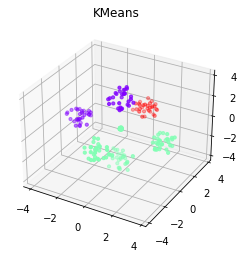

ClusteringType.KMeans with MetricType.DaviesBouldin
--- 0.3028900623321533 seconds ---
0.0%
50.0%
Best match is 3 clusters  [linkage = ward, metrics = MetricType.Silhouette] 
Clustering done for ward
0.0%
50.0%
Best match is 3 clusters  [linkage = complete, metrics = MetricType.Silhouette] 
Clustering done for complete
0.0%
50.0%
Best match is 3 clusters  [linkage = average, metrics = MetricType.Silhouette] 
Clustering done for average
0.0%
50.0%
Best match is 3 clusters  [linkage = single, metrics = MetricType.Silhouette] 
Clustering done for single


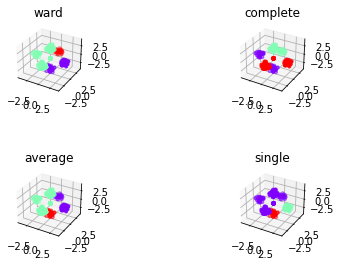

ClusteringType.AgglomerativeClustering with MetricType.Silhouette
--- 0.4923872947692871 seconds ---
0.0%
50.0%
Best match is 3 clusters  [linkage = ward, metrics = MetricType.DaviesBouldin] 
Clustering done for ward
0.0%
50.0%
Best match is 3 clusters  [linkage = complete, metrics = MetricType.DaviesBouldin] 
Clustering done for complete
0.0%
50.0%
Best match is 3 clusters  [linkage = average, metrics = MetricType.DaviesBouldin] 
Clustering done for average
0.0%
50.0%
Best match is 3 clusters  [linkage = single, metrics = MetricType.DaviesBouldin] 
Clustering done for single


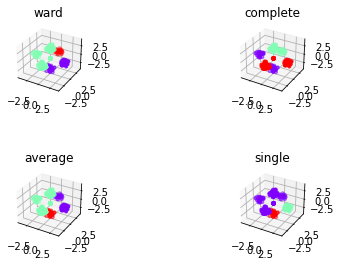

ClusteringType.AgglomerativeClustering with MetricType.DaviesBouldin
--- 0.4097321033477783 seconds ---
0.0%
2.083333333333333%
4.166666666666666%
6.25%
8.333333333333332%
10.416666666666668%
12.5%
14.583333333333334%
16.666666666666664%
18.75%
20.833333333333336%
22.916666666666664%
25.0%
27.083333333333332%
29.166666666666668%
31.25%
33.33333333333333%
35.41666666666667%
37.5%
39.58333333333333%
41.66666666666667%
43.75%
45.83333333333333%
47.91666666666667%
50.0%
52.083333333333336%
54.166666666666664%
56.25%
58.333333333333336%
60.416666666666664%
62.5%
64.58333333333334%
66.66666666666666%
68.75%
70.83333333333334%
72.91666666666666%
75.0%
77.08333333333334%
79.16666666666666%
81.25%
83.33333333333334%
85.41666666666666%
87.5%
89.58333333333334%
91.66666666666666%
93.75%
95.83333333333334%
97.91666666666666%
Best match with min_cluster_size = 7


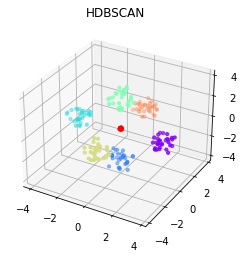

ClusteringType.HDBSCAN with MetricType.Silhouette
--- 6.41290283203125 seconds ---
0.0%
2.083333333333333%
4.166666666666666%
6.25%
8.333333333333332%
10.416666666666668%
12.5%
14.583333333333334%
16.666666666666664%
18.75%
20.833333333333336%
22.916666666666664%
25.0%
27.083333333333332%
29.166666666666668%
31.25%
33.33333333333333%
35.41666666666667%
37.5%
39.58333333333333%
41.66666666666667%
43.75%
45.83333333333333%
47.91666666666667%
50.0%
52.083333333333336%
54.166666666666664%
56.25%
58.333333333333336%
60.416666666666664%
62.5%
64.58333333333334%
66.66666666666666%
68.75%
70.83333333333334%
72.91666666666666%
75.0%
77.08333333333334%
79.16666666666666%
81.25%
83.33333333333334%
85.41666666666666%
87.5%
89.58333333333334%
91.66666666666666%
93.75%
95.83333333333334%
97.91666666666666%
Best match with min_cluster_size = 7


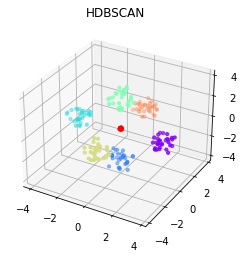

ClusteringType.HDBSCAN with MetricType.DaviesBouldin
--- 7.151775121688843 seconds ---


array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [95]:
PATH = "dataset/"
name_file = "h.data"

# Plot data
X = extractDataAndPrepareData(PATH+name_file)
showData(X)

# K-Means
MAX_N_CLUSTERS = 4 # KMeans and Agglomerative Clustering
type_clustering = ClusteringType.KMeans
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=True) # DaviesBouldin

# Agglomerative Clustering
MAX_N_CLUSTERS = 4 # KMeans and Agglomerative Clustering
type_clustering = ClusteringType.AgglomerativeClustering
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=True) # DaviesBouldin

"""
# DBSCAN
START_EPS,END_EPS,STEP_EPS = 0.01,3,0.1 # Only DBSCAN
MAX_MIN_N_SAMPLES,STEP_SIZE_N_SAMPLES = 50, 2 # Only DBSCAN
 # Only DBSCAN
type_clustering = ClusteringType.DBSCAN
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=True) # DaviesBouldin
"""

# HDBSCAN
MAX_MIN_CLUSTER_SIZE = 50 # Only HDBSCAN
type_clustering = ClusteringType.HDBSCAN
makeClustering(PATH+name_file,type_clustering,MetricType.Silhouette,
                   display=True,verbose=True) # Silhouette
makeClustering(PATH+name_file,type_clustering,MetricType.DaviesBouldin,
                   display=True,verbose=True) # DaviesBouldin